In [9]:
# %% Install necessary packages
!pip install kaggle librosa numpy tensorflow keras sklearn


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# %% Mount Google Drive for dataset access
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# %% Kaggle API setup and dataset download
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download mansourehk/shemo-persian-speech-emotion-detection-database


cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mansourehk/shemo-persian-speech-emotion-detection-database
License(s): unknown
 99% 818M/829M [00:06<00:00, 136MB/s]
100% 829M/829M [00:06<00:00, 135MB/s]


In [ ]:
# %% Unzip dataset
!unzip /content/shemo-persian-speech-emotion-detection-database.zip -d persian-speech-emotion-detection-database


Streaming output truncated to the last 5000 lines.
  inflating: persian-speech-emotion-detection-database/transcript/final script/F24A22.tra  
  inflating: persian-speech-emotion-detection-database/transcript/final script/F24A23.tra  
  inflating: persian-speech-emotion-detection-database/transcript/final script/F24A24.tra  
  inflating: persian-speech-emotion-detection-database/transcript/final script/F24A25.tra  
  inflating: persian-speech-emotion-detection-database/transcript/final script/F24A26.tra  
  inflating: persian-speech-emotion-detection-database/transcript/final script/F24A27.tra  
  inflating: persian-speech-emotion-detection-database/transcript/final script/F24A28.tra  
  inflating: persian-speech-emotion-detection-database/transcript/final script/F24A29.tra  
  inflating: persian-speech-emotion-detection-database/transcript/final script/F24A30.tra  
  inflating: persian-speech-emotion-detection-database/transcript/final script/F24A31.tra  
  inflating: persian-speech-e

In [ ]:
!pip install tensorflow-hub
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
import librosa
import numpy as np
import pandas as pd
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Conv1D, MaxPooling1D, BatchNormalization, Input, Layer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import shap
import random



In [ ]:
def augment_audio(y, sr):

    if random.random() > 0.5:

        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=random.uniform(-2, 2))


    if random.random() > 0.5:
        y = librosa.effects.time_stretch(y, rate=random.uniform(0.8, 1.2))


    if random.random() > 0.5:
        noise = np.random.randn(len(y))
        y = y + 0.005 * noise

    return y


def extract_features(audio_path, max_len=200, n_mfcc=40):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        y = augment_audio(y, sr)  # Apply augmentation
    except Exception as e:
        raise ValueError(f"Error loading audio file: {audio_path} - {e}")

    # Use both MFCCs and chroma features for more robust representation
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T
    chroma = librosa.feature.chroma_stft(y=y, sr=sr).T
    combined = np.hstack([mfcc, chroma])

    if len(combined) > max_len:
        combined = combined[:max_len]
    else:
        combined = np.pad(combined, ((0, max_len - len(combined)), (0, 0)), mode='constant', constant_values=0)

    return combined


In [10]:
src_male = "/content/persian-speech-emotion-detection-database/male"
src_female = "/content/persian-speech-emotion-detection-database/female"
destination = "/content/persian-speech-emotion-detection-database/train"

os.makedirs(destination, exist_ok=True)

# Copy files to train folder
for filename in os.listdir(src_male):
    if filename.endswith(".wav"):
        shutil.copy(os.path.join(src_male, filename), os.path.join(destination, filename))

for filename in os.listdir(src_female):
    if filename.endswith(".wav"):
        shutil.copy(os.path.join(src_female, filename), os.path.join(destination, filename))

feature_data = []
labels = []

for filename in os.listdir("persian-speech-emotion-detection-database/train"):
    if filename.endswith(".wav"):
        audio_path = os.path.join("persian-speech-emotion-detection-database/train", filename)
        try:
            features = extract_features(audio_path)
            feature_data.append(features)
            labels.append(filename[1])  # Assuming label is the second character
        except ValueError as e:
            print(f"Error processing file {filename}: {e}")

feature_data = np.array(feature_data)
labels = np.array(labels)


In [11]:
# Standardize the feature data
scaler = StandardScaler()
feature_data = feature_data.reshape(-1, feature_data.shape[-1])
feature_data = scaler.fit_transform(feature_data)
feature_data = feature_data.reshape(-1, 200, feature_data.shape[1])

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(np.unique(labels_encoded))
labels_categorical = to_categorical(labels_encoded, num_classes=num_classes)

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(feature_data, labels_categorical, test_size=0.2, stratify=labels_categorical)

# Compute class weights for imbalanced data
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dict = dict(enumerate(class_weights))


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Bidirectional, LSTM, Dense, Masking
from tensorflow.keras import regularizers

def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=input_shape))

    # Convolutional Layers
    model.add(Conv1D(64, 5, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Bidirectional LSTM Layers
    model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(0.001))))

    # Dense Layers
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model = build_model((200, feature_data.shape[2]), num_classes)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [14]:
from tensorflow.keras.callbacks import EarlyStopping



history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    )


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 164ms/step - accuracy: 0.2716 - loss: 2.5063 - val_accuracy: 0.3967 - val_loss: 2.2300
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - accuracy: 0.3426 - loss: 2.2266 - val_accuracy: 0.4083 - val_loss: 2.0578
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.4000 - loss: 2.0684 - val_accuracy: 0.4500 - val_loss: 1.9515
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - accuracy: 0.4543 - loss: 1.9226 - val_accuracy: 0.4800 - val_loss: 1.8618
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.4984 - loss: 1.8250 - val_accuracy: 0.4867 - val_loss: 1.8020
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.5187 - loss: 1.7317 - val_accuracy: 0.5050 - val_loss: 1.7236
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.5641 - loss: 1.6416 - val_accuracy: 0.5267 - val_loss: 1.6423
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.5857 - loss: 1.5560 - val_accu

In [15]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)

# Create a DataFrame to display the results
import pandas as pd

results_df = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Loss': [train_loss, test_loss],
    'Accuracy': [train_accuracy, test_accuracy]
})

print(results_df)


    Dataset      Loss  Accuracy
0  Training  0.532272  0.955000
1   Testing  1.979380  0.588333


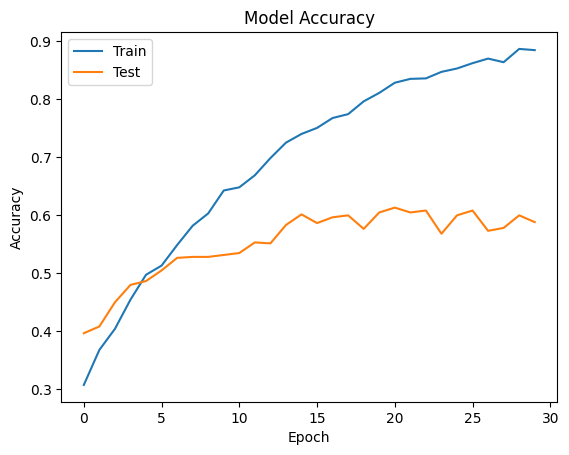

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
True Label: 2
Predicted Label: 2
Prediction Probabilities: [[9.6127167e-03 6.7773857e-04 9.8836017e-01 6.4670667e-04 4.1173247e-04
  2.9086831e-04]]
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
True Label: 2
Predicted Label: 0
Prediction Probabilities: [[7.2371852e-01 2.6698628e-01 8.8873329e-03 3.9306935e-04 1.0374477e-05
  4.4229832e-06]]
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
True Label: 0
Predicted Label: 0
Prediction Probabilities: [[9.8564523e-01 2.1442289e-03 1.2064095e-02 1.1108041e-04 3.3772994e-05
  1.6149916e-06]]
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
True Label: 0
Predicted Label: 0
Prediction Probabilities: [[9.9870896e-01 3.0356491e-04 9.7907358e-04 4.3444861e-06 4.0111590e-06
  5.0415668e-08]]
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
True Label: 2
Predicted Label: 2
Prediction Probabilities: [[0.17541711 0.12363336 0.3676481

In [16]:
# Function to plot training history
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history)

# Function to display random predictions
def display_random_predictions(X_test, y_test, model, label_encoder):
    indices = np.random.choice(range(len(X_test)), 5, replace=False)
    for i in indices:
        audio_features = X_test[i]
        true_label = np.argmax(y_test[i])
        predicted_probs = model.predict(np.expand_dims(audio_features, axis=0))
        predicted_label = np.argmax(predicted_probs)

        print(f"True Label: {label_encoder.inverse_transform([true_label])[0]}")
        print(f"Predicted Label: {label_encoder.inverse_transform([predicted_label])[0]}")
        print(f"Prediction Probabilities: {predicted_probs}")
        print("-" * 30)

display_random_predictions(X_test, y_test, model, label_encoder)
